In this notebook, we have investigated the performance obtained by the XGBoost algorithm, in a complementary analysis to the previous notebook __Tabular Playground Series June 2021 - Gradient Boosting__. For the exploration of the dataset and the performances obtained by the other models tested, refer to the previous notebook. The fine-tuned XGBoost achieved a slightly better log-loss score on the validation data, so it has been submitted for the competition.

In [1]:
# load pycodestyle-magic to be compliant with PEP8 conventions
%load_ext pycodestyle_magic

In [2]:
# activate pycodestyle for each cell
%pycodestyle_on

In [3]:
import sys
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
parameters = {'axes.labelsize': 16,
              'axes.titlesize': 20,
              'xtick.labelsize': 14,
              'ytick.labelsize': 14}
plt.rcParams.update(parameters)

In [5]:
# Load training data
df = pd.read_csv('train.csv')

In [6]:
df.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,target
0,0,0,0,6,1,0,0,0,0,7,0,0,0,3,0,1,0,0,3,3,1,0,2,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,11,0,0,0,0,0,9,0,0,0,0,0,0,3,0,1,3,0,0,0,0,0,0,0,1,1,0,0,3,0,0,0,0,0,0,2,0,0,Class_6
1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,Class_6
2,2,0,0,0,0,0,1,0,3,0,0,1,0,0,0,0,0,0,0,0,5,4,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,5,0,5,0,1,0,0,0,1,0,0,1,0,7,0,1,1,0,3,4,0,0,1,3,0,2,0,0,8,0,0,0,0,1,0,0,0,0,Class_2
3,3,0,0,7,0,1,5,2,2,0,1,2,0,5,0,0,4,0,0,22,2,1,0,0,0,0,3,0,37,0,1,3,13,0,10,0,3,1,1,0,7,0,0,2,0,1,0,0,0,0,0,0,10,0,0,25,1,0,1,2,0,2,0,7,0,0,0,0,4,0,2,2,0,4,3,0,Class_8
4,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Class_2


In [7]:
print('Dataset shape : ', df.shape)
print('Number of classes : ', df['target'].nunique())

Dataset shape :  (200000, 77)
Number of classes :  9


The training dataset contains 200000 products, caracterized by 75 features (positive integers). Each product belongs to one of the 9 classes (column `target`).

In [8]:
# initial size
sys.getsizeof(df)

134400144

In [9]:
df['target'] = df['target'].str[-1]
df = df.astype(np.int16)

In [10]:
all(df.dtypes == 'int16')

True

In [11]:
# final size
sys.getsizeof(df)

30800144

### Train test split + Standard Scaling

In [14]:
X = df.iloc[:, 1:-1].values
y = df['target'].values
X.shape, y.shape

((200000, 75), (200000,))

In [15]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0)

In [16]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_val_std = scaler.transform(X_val)

In [17]:
X_train_std.shape, X_val_std.shape

((160000, 75), (40000, 75))

In [18]:
X_train_std.min(), X_train_std.max()

(-0.7154347566628287, 56.61625243124585)

## Modelisation

In [19]:
X_train_scale = X_train_std
X_val_scale = X_val_std

For this Kaggle competition, the evalution metric is imposed: the cross-entropy loss, which is defined as

$$ \log\ \mathrm{loss} = -\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^My_{ij}\log (p_{ij}) $$

where $N$ is the number of products we want to predict the class they belong to, $M$ is the number of classes (9 here), $y_{ij}$ is equal to 1 if product $i$ belongs to class $j$, otherwise 0, and $p_{ij}$ is the predicted probability for product $i$ to belong to class $j$. 

In [20]:
def train_classifier(classifier, X=X_train_scale, y=y_train, X_val=X_val_scale, y_val=y_val):
    """
    Function that takes a classifier from the sklearn library
    and will train it on provided features X, and labels y.
    Returns log loss on validation data y_val.
    """
    classifier.fit(X, y)
    y_pred = classifier.predict_proba(X_val)
    print(f"Log loss: {round(log_loss(y_val, y_pred),4)}")
    return classifier

1:80: E501 line too long (93 > 79 characters)


### XGBoost

In [54]:
clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=7,
    learning_rate=0.2,
    use_label_encoder=False,
    objective='multi:softprob',
    eval_metric='logloss',
    verbosity=1,
    n_jobs=4,
    random_state=0)

In [55]:
%%time
clf = train_classifier(
    clf,
    y=y_train-1)
# labels are supposed to be encoded from 0 to num_class-1

Log loss: 1.767
Wall time: 2min 3s


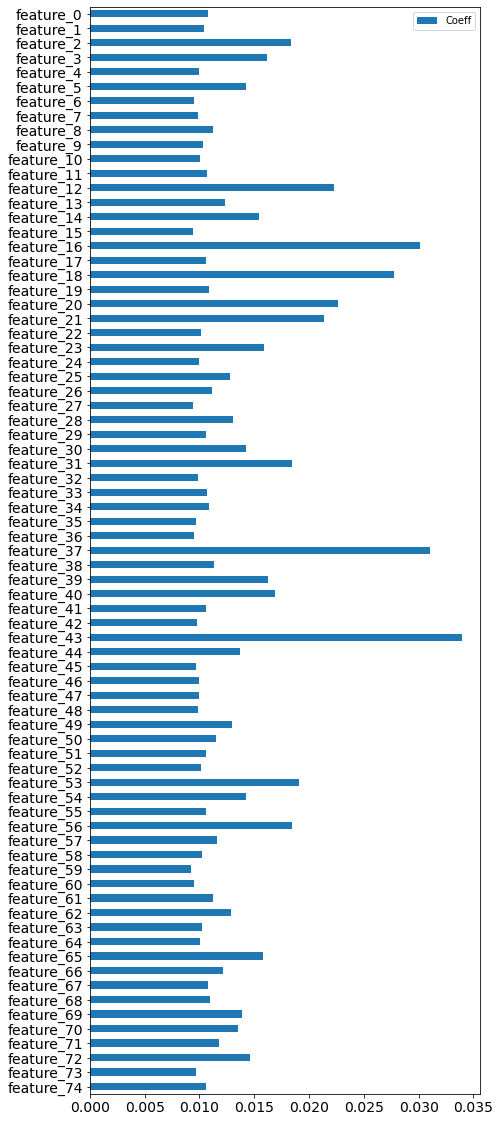

In [56]:
feat = clf.feature_importances_
feat_df = pd.DataFrame(
    {'Coeff': feat},
    index=df.columns[1: -1])
ax = feat_df.plot.barh(figsize=(7,20))
ax.invert_yaxis()
plt.show()

#### Fine Tuning

In [66]:
%%time
model = xgb.XGBClassifier(
    use_label_encoder=False,
    objective='multi:softprob', 
    verbosity=1,
    n_jobs=4,
    random_state=0)
# define parameters to try
n_estimators = [95, 100, 105] 
learning_rates = [0.1, 0.15, 0.2]
max_depths = [2, 3, 4] 
param_grid = {'n_estimators': n_estimators, 
              'max_depth': max_depths, 
              'learning_rate': learning_rates}
xgb_gs = GridSearchCV(
    model,
    param_grid,
    scoring='neg_log_loss',
    cv=3,
    n_jobs=4,
    verbose=3)
xgb_gs.fit(X_train_scale,y_train-1)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  9.4min
[Parallel(n_jobs=4)]: Done  81 out of  81 | elapsed: 32.3min finished


[20:21:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 33min 12s


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=4,
                                     num_parallel_tree=None,
                                     objective='multi:softprob', random_state=0,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=N

In [67]:
xgb_gs.best_params_

{'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 105}

In [68]:
xgb_gs.best_score_

-1.7528079888974044

In [69]:
# saving of model
pickle.dump(
    xgb_gs.best_estimator_, 
    open('TPS_June2021_XGBoost.pkl', 'wb'))

### Submission

In [70]:
df_test = pd.read_csv('test.csv')
print(df_test.shape)
df_test.head()

(100000, 76)


,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74
0,200000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,200001,1,2,0,0,0,0,0,0,0,0,1,0,2,2,0,0,1,0,0,0,2,0,0,1,0,3,0,1,0,0,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,3,2,0,0,0,0,0,0,1,7,0,1,3,1,3,0,0,0,0,3,0,0
2,200002,0,1,7,1,0,0,0,0,6,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,2,0,0,4,0,0,0,0,0,0,0,0,1,0,0,4,0,0,1,0,0,0,6,0,0,2,10,0,0,0,2,1,0,0,0,0,0,3,0,0,0,0,3,0,2,0,0
3,200003,0,0,0,4,3,1,0,0,0,0,7,0,0,0,7,0,0,0,5,0,1,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,7,5,0,0,0,0,0,0,0,0,0,2,3,0,0,0,1,0,0,0,0,0,4,0,0,0,1,0,0,0,4,0,0
4,200004,0,0,5,0,0,0,0,0,0,8,1,0,2,0,0,0,0,0,9,1,0,0,0,0,0,0,0,0,3,0,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,2,2,1,5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [71]:
X_test = df_test.iloc[:, 1:].values
X_test_scale = scaler.transform(X_test)

In [72]:
test_pred = xgb_gs.best_estimator_.predict_proba(
    X_test_scale)

In [73]:
# saving the results
res = pd.DataFrame()
res['id'] = df_test['id']
res[['Class_' + str(i) for i in range(1, 10)]] = test_pred
res.to_csv('submission_XGBoost.csv', index=False)

In [74]:
res.head()

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,200000,0.045821,0.351450,0.160843,0.024845,0.012526,0.187091,0.028931,0.069896,0.118598
1,200001,0.042791,0.111484,0.068567,0.019603,0.013183,0.250253,0.073179,0.289520,0.131421
2,200002,0.032212,0.032860,0.025458,0.014001,0.009077,0.641698,0.033381,0.142926,0.068387
3,200003,0.061114,0.127941,0.092992,0.033721,0.016378,0.230577,0.066094,0.189094,0.182089
4,200004,0.041079,0.118917,0.078580,0.032170,0.016028,0.327120,0.058447,0.193214,0.134444


In [79]:
classes = np.argmax(test_pred, axis=1)
df_test['target'] = classes.tolist()
df_test.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,target
0,200000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,200001,1,2,0,0,0,0,0,0,0,0,1,0,2,2,0,0,1,0,0,0,2,0,0,1,0,3,0,1,0,0,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,3,2,0,0,0,0,0,0,1,7,0,1,3,1,3,0,0,0,0,3,0,0,7
2,200002,0,1,7,1,0,0,0,0,6,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,2,0,0,4,0,0,0,0,0,0,0,0,1,0,0,4,0,0,1,0,0,0,6,0,0,2,10,0,0,0,2,1,0,0,0,0,0,3,0,0,0,0,3,0,2,0,0,5
3,200003,0,0,0,4,3,1,0,0,0,0,7,0,0,0,7,0,0,0,5,0,1,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,7,5,0,0,0,0,0,0,0,0,0,2,3,0,0,0,1,0,0,0,0,0,4,0,0,0,1,0,0,0,4,0,0,5
4,200004,0,0,5,0,0,0,0,0,0,8,1,0,2,0,0,0,0,0,9,1,0,0,0,0,0,0,0,0,3,0,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,2,2,1,5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,5


In [80]:
y_values_train = df['target'].value_counts(
    normalize=True)
y_values_test = df_test['target'].value_counts(
    normalize=True)
x, y_test, y_train = np.arange(9), np.zeros(9), np.zeros(9)
y_test[y_values_test.index] = y_values_test.values
y_train[y_values_train.index-1] = y_values_train.values

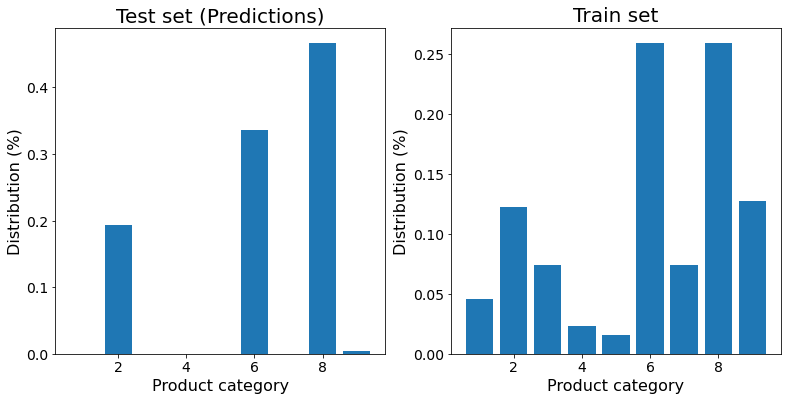

In [81]:
# display predicted and train classes distribution
fig, ax = plt.subplots(1, 2, figsize=(13, 6))
# first plot
ax[0].bar(x+1, y_test)
ax[0].set_title('Test set (Predictions)')
ax[0].set_xlabel('Product category')
ax[0].set_ylabel('Distribution (%)')
# second plot
ax[1].bar(x+1, y_train)
ax[1].set_title('Train set')
ax[1].set_xlabel('Product category')
ax[1].set_ylabel('Distribution (%)')
plt.show()